In [1]:
import getfem as gf
import numpy as np
import pyvista as pv

np.set_printoptions(suppress=True, precision=4)
pv.start_xvfb()

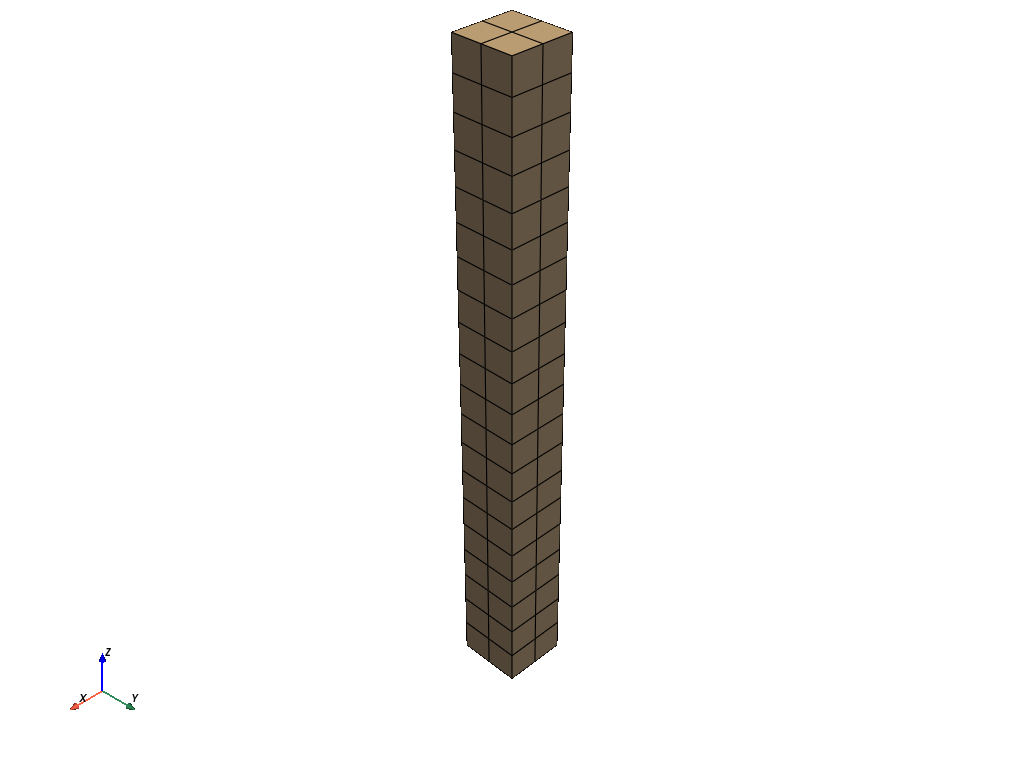

In [2]:
b = 1000.0  # mm
h = 1000.0  # mm
L = 10000.0  # mm
X = np.linspace(0.0, b, 2 + 1)
Y = np.linspace(0.0, h, 2 + 1)
Z = np.linspace(0.0, L, 20 + 1)
mesh = gf.Mesh("cartesian", X, Y, Z)
mesh.export_to_vtk("mesh.vtk", "ascii")
m = pv.read("mesh.vtk")
m.plot(show_edges="True", jupyter_backend="static")

In [3]:
elements_degree = 2
mfu = gf.MeshFem(mesh, 3)
mfu.set_classical_fem(elements_degree)
mfd = gf.MeshFem(mesh, 1)
mfd.set_classical_fem(elements_degree)

In [4]:
mim = gf.MeshIm(mesh, elements_degree * 2)
print(mim)


BEGIN MESH_IM

 CONVEX 0 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 1 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 2 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 3 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 4 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 5 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 6 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 7 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 8 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 9 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 10 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 11 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 12 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4

In [5]:
rho = 7.874e-06  # kg/mm3
M = gf.asm_mass_matrix(mim, mfu)
M.scale(rho)

In [6]:
E = 205000.0  # N/mm2
Nu = 0.0
Lambda = E * Nu / ((1 + Nu) * (1 - 2 * Nu))
Mu = E / (2 * (1 + Nu))
Lambdas = np.repeat([Lambda], mfd.nbdof())
Mus = np.repeat(Mu, mfd.nbdof())
K = gf.asm_linear_elasticity(mim, mfu, mfd, Lambdas, Mus)

In [ ]:
A = np.linalg.inv(M.full()) @ K.full()
omega2, vecs = np.linalg.eig(A)

In [ ]:
omega2_sort = np.sort(omega2)
sort_index = np.argsort(omega2)

In [ ]:
print(omega2_sort[:10])

In [ ]:
f1 = np.sqrt(omega2_sort[6]) / (2.0 * np.pi)
print("{:.4g} Hz".format(f1.real))

In [ ]:
U = vecs[:, sort_index[6]].real
mfu.export_to_vtk("mfu.vtk", "ascii", mfu, U, "U")

In [ ]:
m = pv.read("mfu.vtk")
m.plot(scalars="U", jupyter_backend="static")

In [ ]:
w = m.warp_by_vector("U", factor=10000.0)
w.plot(scalars="U", jupyter_backend="static")

In [ ]:
clambda = 4.730
A = b * h
I = b * h ** 3 / 12.0
f = 1.0 / (2.0 * np.pi) * clambda ** 2 / L ** 2 * np.sqrt((E * I) / (rho * A))
print("f = {:.4g} Hz".format(f))

In [ ]:
from scipy import io
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

In [ ]:
K.save("mm", "K.mtx")
M.save("mm", "M.mtx")

In [ ]:
pk = io.mmread("K.mtx")
pm = io.mmread("M.mtx")

plt.rcParams["font.size"] = 20
fig = plt.figure(figsize=(30, 15))
fig.suptitle("K and M Matrix profiles")
ax1 = fig.add_subplot(1, 2, 1)
ax1.spy(pk, markersize=0.01)
ax1.set_title("K Matrix")
ax2 = fig.add_subplot(1, 2, 2)
ax2.spy(pm, markersize=0.01)
ax2.set_title("M Matrix")
plt.show(block=True)

In [ ]:
omega2, vecs = eigsh(A=pk, M=pm, k=10, sigma=-0.0001, which="LA")

In [ ]:
print(omega2)

In [ ]:
f1 = np.sqrt(omega2[6]) / (2.0 * np.pi)
print("f = {:.4g} Hz".format(f1.real))